# Evaluating uncertainty in sklearn

## Can we measure uncertainity in a classification routine?

As previously, we need to load and prepare our dataset. This is discussed in detail in our introduction notebook, so won't be repeated here.

First, we load the data:

In [1]:
import pandas as pd
dataset_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
data = pd.read_csv(dataset_url, sep=';')

Next, we decide what will be our features and targets. Initially, we will work with the classification attribute "quality", though this will change later in the notebook so we can see how the approaches can differ for continuous datasets compared to this dis-continuous attribute.

Once split, our data is also prepared for use by splitting into training and test groups too:

In [2]:
y = data.quality
x = data.drop('quality', axis=1) # Removes quality from data, provides all other features

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.2, 
                                                    random_state=123, 
                                                    stratify=y)

For consistency with the previous introduction notebook, we will also still work with the `RandomForestClassifier` as optimised with a `GridSearchCV`.

In [3]:
# Declare data preprocessing steps
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(preprocessing.StandardScaler(), 
                         RandomForestClassifier())

# Declare hyperparameters to tune
hyperparameters = { 'randomforestclassifier__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestclassifier__max_depth': [None, 5, 3, 1]}

# Tune model using cross-validation pipeline
from sklearn.model_selection import GridSearchCV
gridRF = GridSearchCV(pipeline, hyperparameters, cv=10)

Now we will train our model as normal:

In [4]:
gridRF.fit(x_train, y_train)

/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid={'randomforestclassifier__max_depth': [None, 5, 3, 1],
                         'randomforestclassifier__max_features': ['auto',
                                                                  'sqrt',
                                                                  'log2']})

Now done, we can start to make predictions. Previously we have seend the `predict()` function; here we are also going to use the `predict_proba()` function, which tells us the probability that any one prediction falls into the classification options.

In [5]:
# 9. Evaluate model pipeline on test data
pred = gridRF.predict(x_test)
pred_proba = gridRF.predict_proba(x_test)

If we inspect the outputs from `pred` and `pred_proba`, we'll see they are very different objects. Let's very crudely look at shape of both objects, and the first entries:

In [6]:
print(len(pred), len(pred_proba))
print(pred[0], pred_proba[0])

320 320
7 [0.   0.   0.1  0.34 0.55 0.01]


So *predictions* are a distinct entry, whereas the *probability* gives the percentage probability that an item falls into each classification option (and the highest percentage is the option returned). We can see this plotted as:

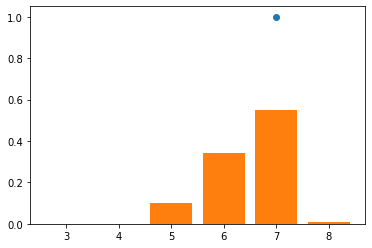

In [7]:
# Prepare the plot object and x-axis
import matplotlib.pyplot as plt
import numpy as np
x_plot = np.arange(3,8+1)

# Plot data
plt.scatter(pred[0],1)
plt.bar(x_plot, pred_proba[0])
plt.show()

Note here that we haven't actually given any quantitative uncertainty on the predictions - even though the data *appears* continuous, increasing from 3 to 8, it is actually discontinuous and so this is still a classification. Thus, error bars are ill-defined; this can be imagined if instead of numbers we had colours on the x-axis. In summary, you either correctly classify, or not!

Nevertheless, we can qualitatively see whether the prediction is confidently made by seeing what the competing classification options were.

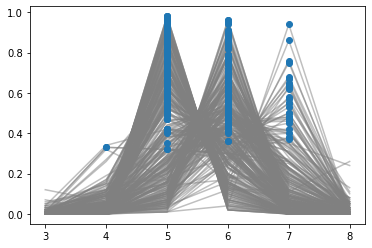

In [8]:
y_data_plot = []

for p, pa in zip(pred, pred_proba):
    # This plots the prediction probability for each classification
    plt.plot(x_plot, pa, color='gray', alpha=0.5, zorder=1)
    y_data_plot.append(pa[p-min(y)])

# And this plots the actual predictions made
plt.scatter(pred, y_data_plot, zorder=2)
plt.show()

Perhaps the most informative aspect of this data is it shows some predictions are more confident than others!

## So for what kind of data can we derive uncertainity?

Thus far, we've shown that uncertainity is only available in a qualitiative manner for classification routines. For regression, however, routines that are based on probability allow us to calculate standard deviation (and thus confidence) in predictions fairly easily.

Let's first look back at our dataset and pick a continuous feature that we can fit try in a regression model.

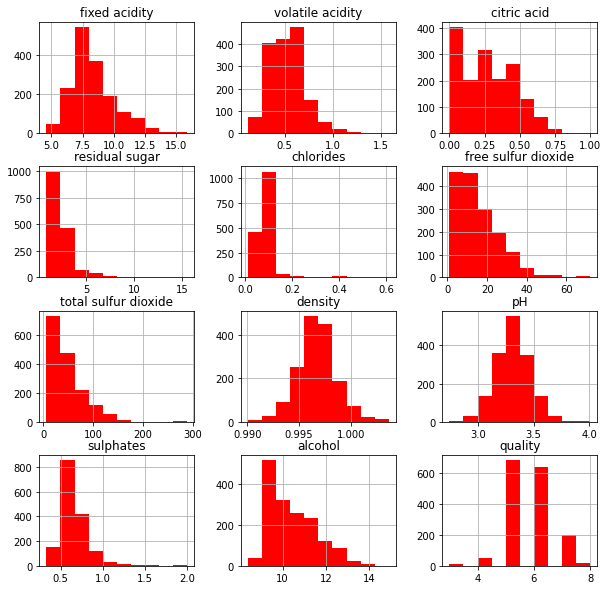

In [9]:
data.hist(figsize=(10,10), color='red')
plt.show()

Looking at this data, one of the most evenly distributed to the pH of the wine. So now we'll recreate our `x` and `y` data objects, with `y` (the target observable) being the wine pH; we'll then split our dataset and also scale it, as we are not doing a cross-validation at this point:

In [10]:
y = data.pH
x = data.drop('pH', axis=1) # Removes quality from data, provides all other features

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.2, 
                                                    random_state=123)

from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(x_train)
# and now transform the data
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

Next we load a probability based regression method. Here we have used the `GaussianProcessRegressor` (GPR), though other examples exist (information taken from this informative post: https://datascience.stackexchange.com/questions/31773/how-to-estimate-the-variance-of-regressors-in-scikit-learn)

One of the key features for the GPR is the `kernel`, i.e. the mathematical function used to fit the training data. These can take pre-defined forms or combinations - a full description is available on this informative webpage: https://www.cs.toronto.edu/~duvenaud/cookbook/. Here, we have defined a range of different kernels, lifted from this page: https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_prior_posterior.html, so we can demonstrate their strengths and weaknesses at fitting to the dataset.

In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)

# Lifted from https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_prior_posterior.html
kernels = [1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
           1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1),
           1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0,
                                length_scale_bounds=(0.1, 10.0),
                                periodicity_bounds=(1.0, 10.0)),
           ConstantKernel(0.1, (0.01, 10.0))
               * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2),
           1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),
                        nu=1.5)]

At this point we have 5 kernels defined. We will now iterate through these kernels in a for loop, testing their suitability at both making predictions when trained on our data **and** also displaying the confidence interval on these predictions. 

By standard, GPR returns a standard deviation. This really tells us the data spread, not the confidence of the prediction that we want; as outlined from the following two links, the conversion of between standard deviation is trivial algebra:
- https://www.dummies.com/education/math/statistics/how-to-calculate-a-confidence-interval-for-a-population-mean-when-you-know-its-standard-deviation/
- https://stackoverflow.com/questions/58899202/plotting-the-standard-deviation-of-a-gaussian-process 

To make our life easier, we'll define a function that performs the analysis; this makes the presentation a bit neater:

In [12]:
from sklearn.metrics import mean_squared_error, r2_score
def print_and_plot(name, y_test, pred, std=None, label=None):
    print(name)
    print("R2: ", r2_score(y_test, pred), "; MSE: ", mean_squared_error(y_test, pred))
    
    if std is not None:
        print("Average STD: ", sum(std)/len(std))
        # Convert the standard deviation to the confidence interval and plot
        ci = 1.96*std
        plt.errorbar(y_test,pred,yerr=ci, linestyle="None", alpha=0.5, zorder=1)
        
    # Plot the datapoints on the graph
    plt.scatter(y_test, pred, label=label, zorder=2)    

And now we'll test the `kernels`:

<class 'sklearn.gaussian_process.kernels.Product'>
R2:  0.7437893673487194 ; MSE:  0.006084205620326319
Average STD:  0.04918355482820612


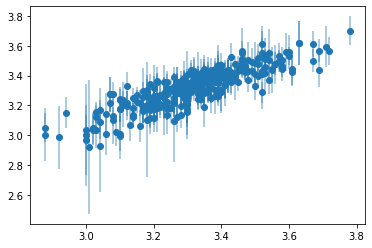

<class 'sklearn.gaussian_process.kernels.Product'>
R2:  0.7309448580949056 ; MSE:  0.006389222764164967
Average STD:  0.028030228119575628


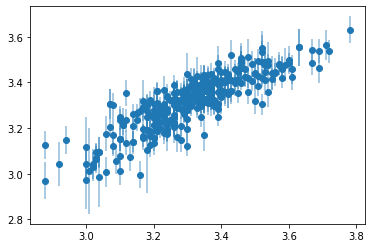

<class 'sklearn.gaussian_process.kernels.Product'>
R2:  -196.09108253384215 ; MSE:  4.680300187622238
Average STD:  0.0055903053279085044


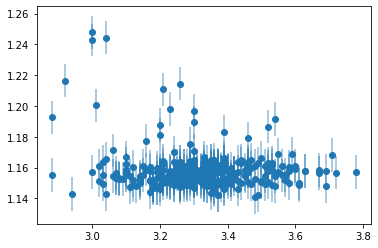

<class 'sklearn.gaussian_process.kernels.Product'>
R2:  0.7685865472559966 ; MSE:  0.005495349725475755
Average STD:  0.06782382995293539


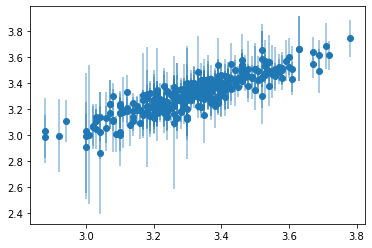

<class 'sklearn.gaussian_process.kernels.Product'>
R2:  0.7697250769728791 ; MSE:  0.005468313185927481
Average STD:  0.0783776719394009


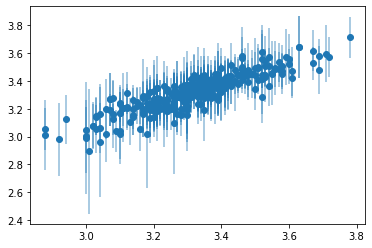

In [13]:
for kernel in kernels:
    # If you encounter issues, consider increasing n_restarts_optimizer
    GPR = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, alpha=0.1)
    try:
        GPR.fit(x_train_scaled, y_train)
        pred, std = GPR.predict(x_test_scaled, return_std=True)
        print_and_plot(type(kernel), y_test, pred, std)
        plt.show()
    except:
        print("Failed to fit with " + type(kernel))
        break

The alternative approach given above is the `BayesianRidge` regressor, which stems from Bayesian statistics (i.e. probability based statistics). See https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html for more details.

<class 'sklearn.linear_model._bayes.BayesianRidge'>
R2:  0.7324474945410548 ; MSE:  0.006353539822296543
Average STD:  0.08638118763212946


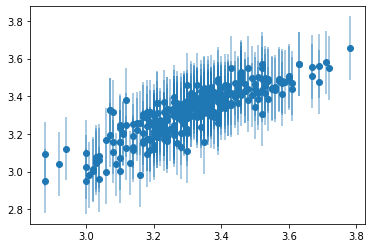

In [14]:
from sklearn.linear_model import BayesianRidge
BR = BayesianRidge()
BR.fit(x_train_scaled, y_train)
pred, std = BR.predict(x_test_scaled, return_std=True)
print_and_plot(type(BR), y_test, pred, std)
plt.show()

## Calculating confidence intervals in the absence of a probabilistic fitted model

If confidence intervals are needed but we are not using a probabilistic method, we can still generate data to give us statistical probabilities - this is done by sampling, fitting and testing our model multiple times, and then collecting all the results to statistically draw out our confidence levels. Here we could use any supervised learning option (https://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html), or for that matter the probablistic of classification methods given above.

For simplicity (and to keep my life interesting), we'll continue to use the `BayesianRidge` regression in this example. Our example for realising the bootstrapping approach is derived from the work on this page: https://machinelearningmastery.com/calculate-bootstrap-confidence-intervals-machine-learning-results-python/, which looks at bootstrapping for confidence in a model's predictions.

Firstly, we need to load functionality from `sklearn` to sample our training data randomly and repeatedly. This is done with `resample`

In [15]:
from sklearn.utils import resample

Next we need to define how many times we'll refit our model, and with what proportion of the data (here I'm using training data, but one could use all data if prefered). We also need a data object to save results so we can subsequently do the statistical analysis on predictions:

In [16]:
# configure bootstrap
n_iterations = 5
n_size = int(len(x_train_scaled) * 0.20)
# bootstrap data
all_predictions = np.zeros((len(y_test), n_iterations))

Remember that `y_test` here is the variable with testing observables, defined initially; we are just using it to define list lengths.

The process essentially involves refitting the model `n_iterations` times using samples of `n_samples` size, collecting all the outcomes as we go

In [17]:
for i in np.arange(n_iterations):
    # prepare training sets
    x_tr_scaled, y_tr = resample(x_train_scaled, y_train, n_samples=n_size)
    # fit model
    model = BayesianRidge()
    model.fit(x_tr_scaled, y_tr)
    # evaluate model
    pred_bootstrap = model.predict(x_test_scaled)
    # store predictions
    for y in np.arange(len(y_test)):
        all_predictions[y][i] = pred_bootstrap[y]

Now we just need to work out the 95% confidence interval. To do this, we are going to identify the boundary to the lowest and highest 2.5% of results (i.e. the range of 2.5% to 97.5% of our results). As we need to work out the confidence interval for each data point, we stored the result in a list for plotting. 

In [18]:
# confidence intervals for each testing value
alpha = 0.95
mean = np.zeros(len(y_test))
ci = np.zeros((2, len(y_test)))

for y in np.arange(len(y_test)):
    mean[y] = (sum(all_predictions[y])/len(all_predictions[y]))
    p = ((1.0-alpha)/2.0) * 100
    lower = np.percentile(all_predictions[y], p)
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = np.percentile(all_predictions[y], p)
    ci[0][y] = mean[y]-lower
    ci[1][y] = upper-mean[y]

Finally, let's replot our data against the original standard deviation calculated from the `BayesianRidge` approach alone:

R2:  0.9975550922173877 ; MSE:  4.1074199528524596e-05


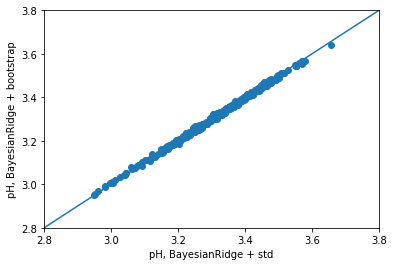

In [19]:
print("R2: ", r2_score(pred, mean), "; MSE: ", mean_squared_error(pred, mean))

#plt.errorbar(pred, mean, xerr=1.96*std, yerr=ci, linestyle="None", alpha=0.5, zorder=1)
plt.scatter(pred, mean, zorder=2)
# Add a straight line of y=x to indicate if answers are identical
x = np.linspace(2,4)
plt.plot(x,x)
# Add in some labels so we know what the data is
plt.xlim(2.8,3.8)
plt.xlabel("pH, BayesianRidge + std")
plt.ylim(2.8,3.8)
plt.ylabel("pH, BayesianRidge + bootstrap")
plt.show()

Notice here that the errors on the `BayesianRidge` approach are much larger than our bootstrap approach. Also, the error bars for the `BayesianRidge` are perfectly centred around the mean, as they are applied assuming a normal distribution; for our data-sampled approach, the mean is not necessarily in the middle of the error bars.

If you want to improve the fit, one can consider increasing `n_iterations` and `n_size` - give it a try!

More involved bootstrapping approaches are built into `sklearn`, and you can find out about them here: https://machinelearningmastery.com/bagging-ensemble-with-python/